In [1]:
from pycocotools.coco import COCO

dataDir = "dataset/train2014"
dataType = "train2014"
annFile = "dataset/annotations/instances_train2014.json"
imageDir = "dataset/train2014/"

# Initialize the COCO api for instance annotations
coco = COCO(annFile)


loading annotations into memory...
Done (t=4.00s)
creating index...
index created!


In [2]:
categories = coco.loadCats(coco.getCatIds())
for cat in categories:
    print(f"ID: {cat['id']}, Name: {cat['name']}")

ID: 1, Name: person
ID: 2, Name: bicycle
ID: 3, Name: car
ID: 4, Name: motorcycle
ID: 5, Name: airplane
ID: 6, Name: bus
ID: 7, Name: train
ID: 8, Name: truck
ID: 9, Name: boat
ID: 10, Name: traffic light
ID: 11, Name: fire hydrant
ID: 13, Name: stop sign
ID: 14, Name: parking meter
ID: 15, Name: bench
ID: 16, Name: bird
ID: 17, Name: cat
ID: 18, Name: dog
ID: 19, Name: horse
ID: 20, Name: sheep
ID: 21, Name: cow
ID: 22, Name: elephant
ID: 23, Name: bear
ID: 24, Name: zebra
ID: 25, Name: giraffe
ID: 27, Name: backpack
ID: 28, Name: umbrella
ID: 31, Name: handbag
ID: 32, Name: tie
ID: 33, Name: suitcase
ID: 34, Name: frisbee
ID: 35, Name: skis
ID: 36, Name: snowboard
ID: 37, Name: sports ball
ID: 38, Name: kite
ID: 39, Name: baseball bat
ID: 40, Name: baseball glove
ID: 41, Name: skateboard
ID: 42, Name: surfboard
ID: 43, Name: tennis racket
ID: 44, Name: bottle
ID: 46, Name: wine glass
ID: 47, Name: cup
ID: 48, Name: fork
ID: 49, Name: knife
ID: 50, Name: spoon
ID: 51, Name: bowl
ID: 5

In [15]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torchvision.transforms.functional as TF

class COCODataset(Dataset):
    """COCO dataset wrapper that returns resized tensors for image and mask.

    Returns:
        image: torch.FloatTensor (C,H,W) in [0,1]
        mask:  torch.LongTensor (H,W) with integer class ids (0 = background)
    """

    def __init__(self, coco: COCO, image_dir, size=(256, 256), transform=None):
        self.coco = coco
        self.image_dir = image_dir
        self.transform = transform
        self.size = size 
        self.img_ids = self.coco.getImgIds(catIds=[1]) # Person

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = f"{self.image_dir}/{img_info['file_name']}"

        image = Image.open(img_path).convert("RGB")

        orig_w, orig_h = image.size
        mask = np.zeros((orig_h, orig_w), dtype=np.uint8)
        for i, ann in enumerate(anns, 1):
            ann_mask = self.coco.annToMask(ann).astype(np.uint8)
            mask[ann_mask == 1] = i

        if self.size is not None:
            image = image.resize(self.size, Image.BILINEAR)
            mask = Image.fromarray(mask).resize(self.size, Image.NEAREST)

        image = TF.to_tensor(image)
        mask = torch.from_numpy(np.array(mask)).long()

        if self.transform is not None:
            image = self.transform(image)

        return image, mask


In [20]:
dataset = COCODataset(coco, imageDir, size=(512, 512))


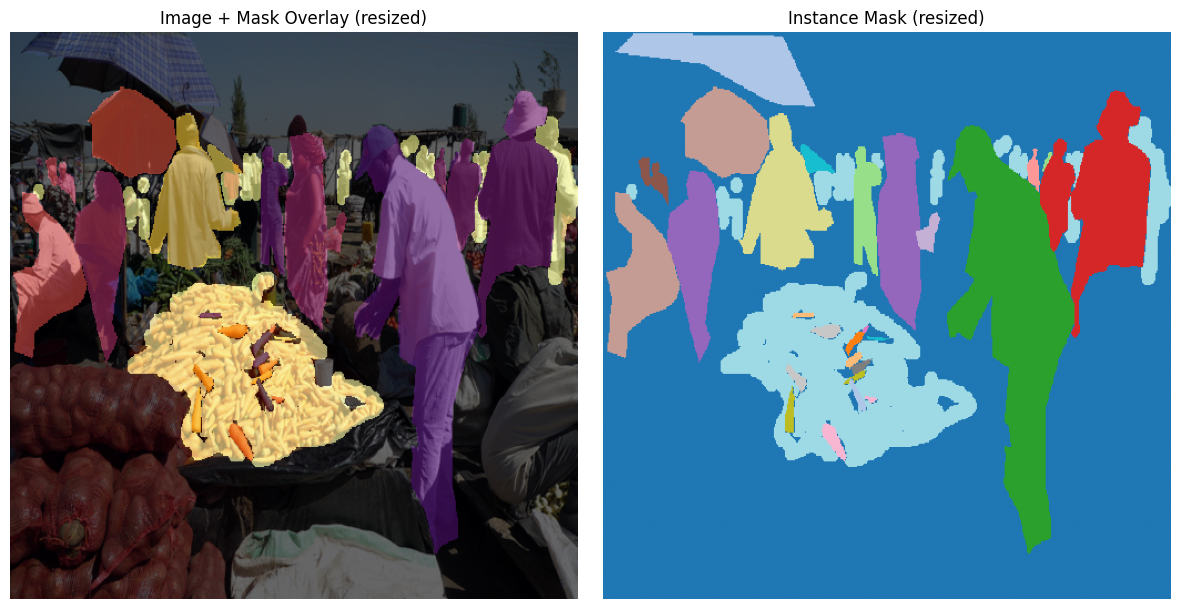

In [22]:
import matplotlib.pyplot as plt

# Fetch a sample (now tensors):
image, mask = dataset[0]

# image: torch.Tensor (C,H,W) in [0,1], mask: torch.LongTensor (H,W)
image_np = image.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.imshow(mask_np, cmap="inferno", alpha=0.6)
plt.title("Image + Mask Overlay (resized)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap="tab20")
plt.title("Instance Mask (resized)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

seed_everything(42)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    mode="min",
)

logger = TensorBoardLogger("logs", name="segmentation")
dataloader = COCODataset(coco, imageDir)

trainer = Trainer(
    max_epochs=10,
    callbacks=[checkpoint_callback],
    logger=logger,
    accelerator="cpu",
)

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [ ]:
from torch.utils.data import DataLoader
from model import SegmentationModel

dataset = COCODataset(coco, imageDir, size=(512, 512))
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = SegmentationModel(n_classes=80)

trainer.fit(model, train_loader)